### Setting up

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 6, Finished, Available)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml import Pipeline
from tabulate import tabulate
from functools import reduce
import matplotlib.dates as mdates

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 7, Finished, Available)

### Loading data

In [3]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_sentiment.parquet"
submissions_path = "/basketball_submissions_sentiment.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 8, Finished, Available)

In [4]:
submissions.show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 9, Finished, Available)

+-----------------+------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+------------+------------+----------------+-----------+--------------+---+-----+----+--------------------+--------+
|        subreddit|author|   author_flair_text|               title|            selftext|        created_utc|num_comments|supported_team|game_thread|home_ranking|   home_team|away_ranking|       away_team|  game_time|ranked_matchup|day|month|year|          clean_text|     col|
+-----------------+------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+------------+------------+----------------+-----------+--------------+---+-----+----+--------------------+--------+
|CollegeBasketball|cbbBot|:rcbb: :ncaa: /r/...|[Game Thread] #3 ...|[UCLA](#f/ucla) *...|2022-02-04 00:00:04|        1172|          rcbb|       true|           5|    

In [4]:
# Rename col sentiment
submissions = submissions.withColumnRenamed("col", "sentiment")
comments = comments.withColumnRenamed("col", "sentiment")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 9, Finished, Available)

In [18]:
submissions.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 23, Finished, Available)

9163

In [19]:
comments.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 24, Finished, Available)

869804

### Sentiment Analysis on Each Team

In [5]:
# Define a dictionary of teams and associated keywords
team_keywords = {
    'houston': ['houston', 'cougars', 'uh', 'uh cougars'],
    'kansas': ['kansas', 'jayhawks', 'ku', 'rock chalk', 'ku jayhawks'],
    'villanova': ['villanova', 'wildcats', 'nova', 'villanova wildcats'],
    'duke': ['duke', 'blue devils', 'duke blue devils'],
    'arkansas': ['arkansas', 'razorbacks', 'hogs', 'u of a', 'arkansas razorbacks'],
    'saint peters': ["saint peter's", 'peacocks', "saint peter's peacocks", 'saint peters', "st. peter's", 'st peters', 'spu'],
    'north carolina': ['north carolina', 'tar heels', 'unc', 'unc tar heels'],
    'miami': ['miami', 'hurricanes', 'um', 'miami hurricanes'],
    'purdue': ['purdue', 'boilermakers', 'purdue boilermakers', 'pu'],
    'illinois': ['illinois', 'fighting illini', 'illini', 'u of i', 'university of illinois']
}

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 10, Finished, Available)

In [6]:
# Define the UDF to check the existence of key words
def keyword_present(text, keywords):
    if text:
        return any(keyword in text for keyword in keywords)
    return False

keyword_udf = udf(keyword_present, BooleanType())

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 11, Finished, Available)

In [7]:
# Apply the UDF
for team, keywords in team_keywords.items():
    submissions = submissions.withColumn(
        team,
        keyword_udf(col("title"), array([lit(k) for k in keywords])) | keyword_udf(col("selftext"), array([lit(k) for k in keywords]))
    )
    comments = comments.withColumn(
        team, 
        keyword_udf(col("body"), array([lit(k) for k in keywords]))
    )

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 12, Finished, Available)

In [45]:
# Check
submissions.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 52, 50, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, author_flair_text: string, title: string, selftext: string, created_utc: timestamp, num_comments: bigint, supported_team: string, game_thread: boolean, home_ranking: string, home_team: string, away_ranking: string, away_team: string, game_time: string, ranked_matchup: boolean, day: int, month: int, year: int, clean_text: string, sentiment: string, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean, purdue: boolean, illinois: boolean]>

In [8]:
from pyspark.sql.functions import sum as sql_sum

# Define the function to aggregate counts by sentiment and team
def aggregate_counts_by_sentiment_and_team(df):
    aggregated_dfs = [df.groupBy("sentiment").agg(sql_sum(col(team).cast("int")).alias(team)) for team in team_keywords.keys()]
    return reduce(lambda df1, df2: df1.join(df2, "sentiment", "outer"), aggregated_dfs)


# Aggregate the counts for submissions by sentiment and team
submissions_aggregated = aggregate_counts_by_sentiment_and_team(submissions)

# Aggregate the counts for comments by sentiment and team
comments_aggregated = aggregate_counts_by_sentiment_and_team(comments)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 13, Finished, Available)

In [16]:
print("Team Mentions and Sentiment Proportion in Submissions")
submissions_aggregated.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 21, Finished, Available)

Team Mentions and Sentiment Proportion in Submissions
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|sentiment|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
| negative|     71|   173|      100|  42|      46|           0|           101|  308|   211|      81|
|  neutral|      2|    30|       25|   3|       2|           0|             8|   53|    15|       3|
| positive|    187|   462|      210| 113|     122|           4|           226| 2611|   404|     265|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [20]:
print("Team Mentions and Sentiment Proportion in Comments")
comments_aggregated.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 25, Finished, Available)

Team Mentions and Sentiment Proportion in Comments
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|sentiment|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
| negative|   1347|  3612|     2233|1111|     237|         359|          6283|19138| 15274|     253|
|  neutral|    190|   494|      307| 158|      41|          39|           849| 2428|  1908|      29|
| positive|   2518|  5109|     3573|1865|     462|         786|         11905|31182| 25010|     361|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [23]:
# Convert the Spark DataFrame to a Pandas DataFrame
submissions_aggregated_pd = submissions_aggregated.toPandas()
comments_aggregated_pd = comments_aggregated.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 28, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 43, Finished, Available)

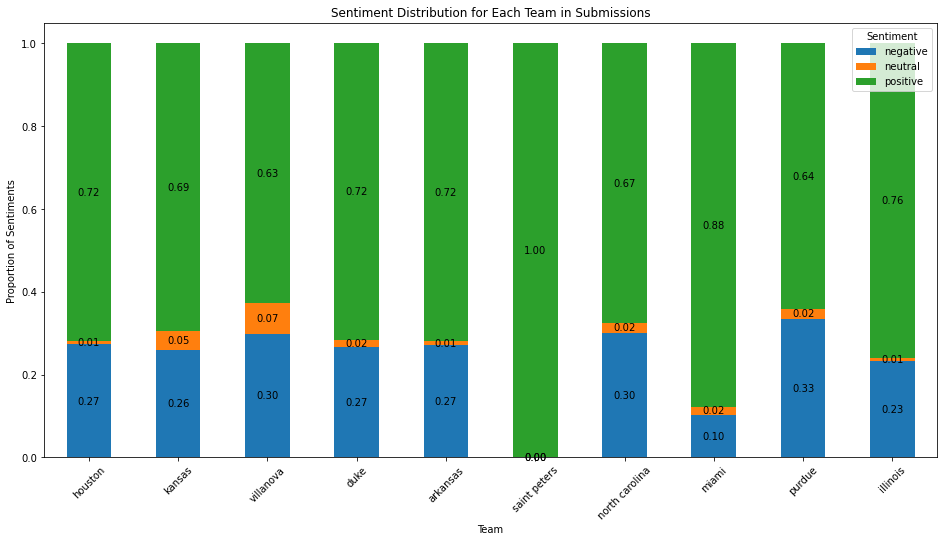

In [38]:
# Calculate the total counts for each team
submissions_total_counts = submissions_aggregated_pd.set_index('sentiment').sum()

# Calculate proportions
submissions_proportions = submissions_aggregated_pd.set_index('sentiment').div(submissions_total_counts)

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
bars = submissions_proportions.T.plot(kind='bar', stacked=True, ax=ax)

# Annotate each bar segment with its proportion
for bar in bars.containers:
    ax.bar_label(bar, fmt='%.2f', label_type='center')

ax.set_xlabel('Team')
ax.set_ylabel('Proportion of Sentiments')
ax.set_title('Sentiment Distribution for Each Team in Submissions')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/sentiment_distribution_for_each_team_in_submissions.png")
plt.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 44, Finished, Available)

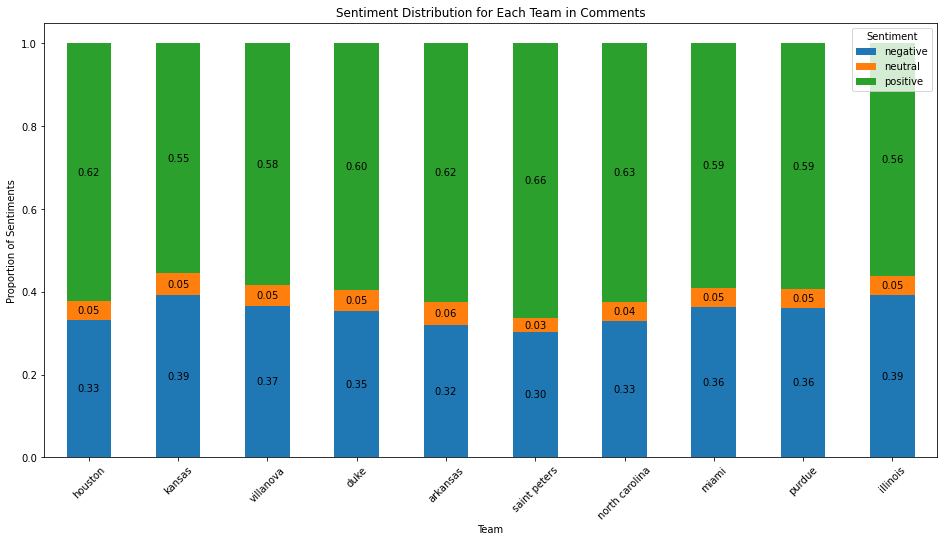

In [39]:
# Calculate the total counts for each team
comments_total_counts = comments_aggregated_pd.set_index('sentiment').sum()

# Calculate proportions
comments_proportions = comments_aggregated_pd.set_index('sentiment').div(comments_total_counts)

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
bars = comments_proportions.T.plot(kind='bar', stacked=True, ax=ax)

# Annotate each bar segment with its proportion
for bar in bars.containers:
    ax.bar_label(bar, fmt='%.2f', label_type='center')

ax.set_xlabel('Team')
ax.set_ylabel('Proportion of Sentiments')
ax.set_title('Sentiment Distribution for Each Team in Comments')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/sentiment_distribution_for_each_team_in_comments.png")
plt.show()

### Daily Mentions and Sentiment Changes and Correlation with Score

In [9]:
# Aggregate the daily mention counts for each team and groupby sentiment
daily_mentions_comments = comments.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day"),
    "sentiment"  # Adding sentiment to the grouping
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina')
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 14, Finished, Available)

In [10]:
# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_comments_pd = daily_mentions_comments.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 15, Finished, Available)

In [49]:
daily_mentions_comments_pd.dtypes

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 52, 54, Finished, Available)

year               int32
month              int32
day                int32
sentiment         object
kansas             int64
north_carolina     int64
dtype: object

In [11]:
url_kansas = 'https://www.sports-reference.com/cbb/schools/kansas/men/2022-schedule.html'
kansas_schedule = pd.read_html(url_kansas, header=0)[1]
kansas_schedule = kansas_schedule[~kansas_schedule['Date'].str.contains('date', case=False, na=False)]
columns_keep = ['Date', 'Opponent', 'Unnamed: 8', 'Tm', 'Opp', 'OT', 'W', 'L', 'Streak']
kansas_schedule = kansas_schedule[columns_keep]

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 16, Finished, Available)

In [12]:
# Convert 'Tm' and 'Opp' columns to integers
kansas_schedule['Tm'] = pd.to_numeric(kansas_schedule['Tm'], errors='coerce')
kansas_schedule['Opp'] = pd.to_numeric(kansas_schedule['Opp'], errors='coerce')

# Create the 'score' column
kansas_schedule['score'] = kansas_schedule['Tm'] - kansas_schedule['Opp']

# Convert 'Date' column to datetime format with specific format string
kansas_schedule['Date'] = pd.to_datetime(kansas_schedule['Date'], format='%a, %b %d, %Y')

# Extract year, month, and day
kansas_schedule['year'] = kansas_schedule['Date'].dt.year
kansas_schedule['month'] = kansas_schedule['Date'].dt.month
kansas_schedule['day'] = kansas_schedule['Date'].dt.day

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 17, Finished, Available)

In [52]:
kansas_schedule.dtypes

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 52, 57, Finished, Available)

Date          datetime64[ns]
Opponent              object
Unnamed: 8            object
Tm                     int64
Opp                    int64
OT                    object
W                     object
L                     object
Streak                object
score                  int64
year                   int64
month                  int64
day                    int64
dtype: object

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 19, Finished, Available)

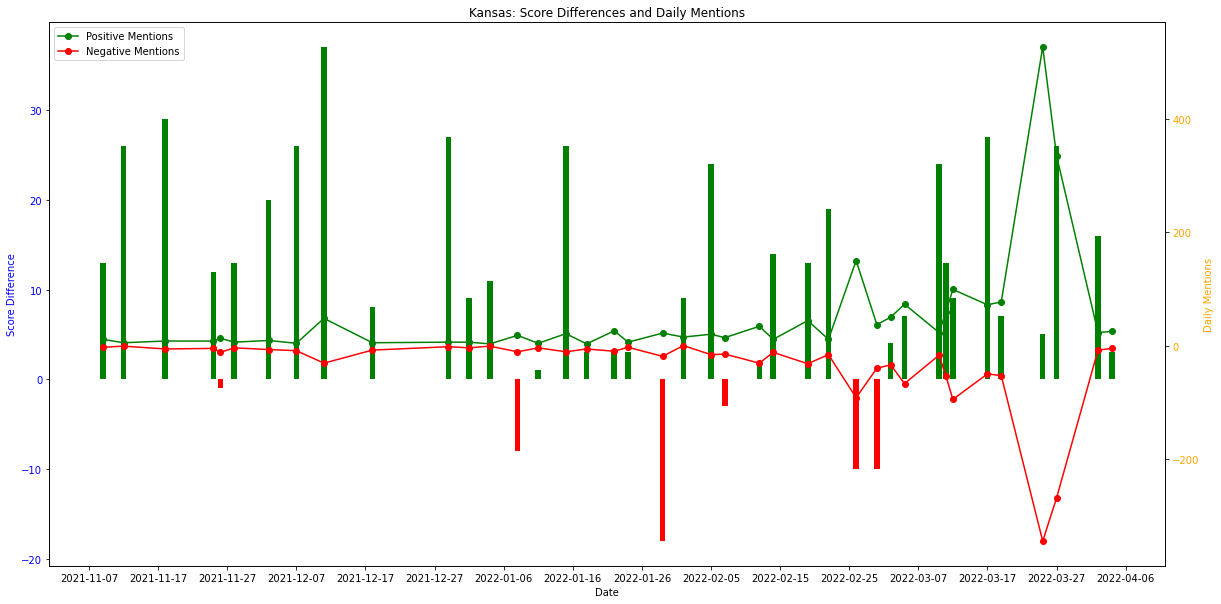

In [14]:
# Separating positive and negative mentions
positive_mentions = daily_mentions_comments_pd[daily_mentions_comments_pd['sentiment'] == 'positive']
negative_mentions = daily_mentions_comments_pd[daily_mentions_comments_pd['sentiment'] == 'negative']

# Merging with the kansas_schedule DataFrame
merged_pos = pd.merge(kansas_schedule, positive_mentions, on=['year', 'month', 'day'], how='left')
merged_neg = pd.merge(kansas_schedule, negative_mentions, on=['year', 'month', 'day'], how='left')

# Creating the figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plotting the score difference as a bar chart
ax1.bar(merged_pos['Date'], merged_pos['score'], color=['green' if x > 0 else 'red' for x in merged_pos['score']])
ax1.set_ylabel('Score Difference', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a secondary axis for daily mentions
ax2 = ax1.twinx()
ax2.plot(merged_pos['Date'], merged_pos['kansas'], color='green', marker='o', linestyle='-', label='Positive Mentions')
ax2.plot(merged_neg['Date'], -merged_neg['kansas'], color='red', marker='o', linestyle='-', label='Negative Mentions')  # Negative mentions inverted
ax2.set_ylabel('Daily Mentions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Setting the x-axis as date
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting titles and labels
plt.title('Kansas: Score Differences and Daily Mentions')
ax1.set_xlabel('Date')
ax2.legend(loc='upper left')

# Show and save the plot
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/kansas_score_differences_and_daily_mentions.png")
plt.show()

In [15]:
unc_url = 'https://www.sports-reference.com/cbb/schools/north-carolina/men/2022-schedule.html'

unc_schedule = pd.read_html(unc_url, header=0)[1]
unc_schedule = unc_schedule[~unc_schedule['Date'].str.contains('date', case=False, na=False)]
unc_schedule = unc_schedule[columns_keep]

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 20, Finished, Available)

In [16]:
# Convert 'Tm' and 'Opp' columns to integers
unc_schedule['Tm'] = pd.to_numeric(unc_schedule['Tm'], errors='coerce')
unc_schedule['Opp'] = pd.to_numeric(unc_schedule['Opp'], errors='coerce')

# Create the 'score' column
unc_schedule['score'] = unc_schedule['Tm'] - unc_schedule['Opp']

# Convert 'Date' column to datetime format with specific format string
unc_schedule['Date'] = pd.to_datetime(unc_schedule['Date'], format='%a, %b %d, %Y')

# Extract year, month, and day
unc_schedule['year'] = unc_schedule['Date'].dt.year
unc_schedule['month'] = unc_schedule['Date'].dt.month
unc_schedule['day'] = unc_schedule['Date'].dt.day

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 21, Finished, Available)

In [62]:
unc_schedule.dtypes

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 52, 67, Finished, Available)

Date          datetime64[ns]
Opponent              object
Unnamed: 8            object
Tm                     int64
Opp                    int64
OT                    object
W                     object
L                     object
Streak                object
score                  int64
year                   int64
month                  int64
day                    int64
dtype: object

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 53, 22, Finished, Available)

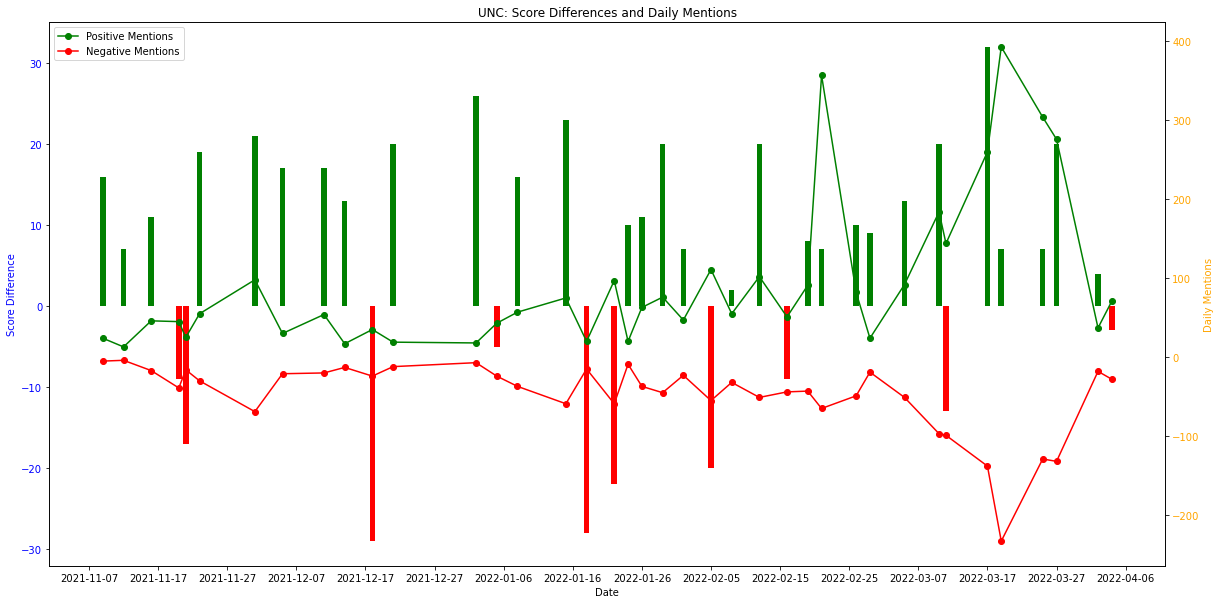

In [17]:
# Merging with the unc_schedule DataFrame
merged_pos = pd.merge(unc_schedule, positive_mentions, on=['year', 'month', 'day'], how='left')
merged_neg = pd.merge(unc_schedule, negative_mentions, on=['year', 'month', 'day'], how='left')

# Creating the figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plotting the score difference as a bar chart
ax1.bar(merged_pos['Date'], merged_pos['score'], color=['green' if x > 0 else 'red' for x in merged_pos['score']])
ax1.set_ylabel('Score Difference', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a secondary axis for daily mentions
ax2 = ax1.twinx()
ax2.plot(merged_pos['Date'], merged_pos['north_carolina'], color='green', marker='o', linestyle='-', label='Positive Mentions')
ax2.plot(merged_neg['Date'], -merged_neg['north_carolina'], color='red', marker='o', linestyle='-', label='Negative Mentions')  # Negative mentions inverted
ax2.set_ylabel('Daily Mentions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Setting the x-axis as date
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting titles and labels
plt.title('UNC: Score Differences and Daily Mentions')
ax1.set_xlabel('Date')
ax2.legend(loc='upper left')

# Show and save the plot
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/unc_score_differences_and_daily_mentions.png")
plt.show()